<a href="https://colab.research.google.com/github/HenryMujati/PRODIGY_ML_03/blob/main/Cats_vs_dogs_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogs-and-cats-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5787571%2F9508552%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T185321Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9064c7fb56ece00c496584cea30b096916bd0631ac2c7751713c9dbfcc145a815da812f473880b32f23b33b0b90c51e9a7cb6b390fdda27ca76076ab509552c3316032f2edeaf072951fe4c8f53286ff7e3e93c63e830f78fca94c5a3ec8e3a1ce62b00e900dddd71573a73b894166f9fb14c0f267cd1515394e7ebb896fc6cad5814e6db7ddaccc3980d4a97ebda07071adf8b7ea7033d37ea76ae29468e06525c570ee547d8def29cdf9a27cdc4ecfa91dc176a86739646376004dbd8f0e1532f4d290c9a98c20b595b981c2aaabf6bcc2c31e59dd0cd9f368bec14952fce90e0a7a1604bb10a525a30a0ac5a9c0251d8fb1ab05abfa6b613d51aa40cbedc4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Support Vector Machine For Cats vs Dogs

In [ ]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

Task-03

Implement a support vector machine (SVM) to classify images of cats and dogs from the Kaggle dataset.



Dataset :- https://www.kaggle.com/c/dogs-vs-cats/data

In [ ]:
directory = '/kaggle/input/dogs-and-cats-data/final_data'
def load_and_preprocess_images(directory, img_size=(128, 128)):
    image_data = []
    labels = []


    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist.")
        return np.array([]), np.array([])

    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            label = 1 if 'dog' in filename else 0 #Cat = 0
            img_path = os.path.join(directory, filename)

            #image to array
            img = Image.open(img_path)
            img = img.resize(img_size)
            img_array = np.array(img)

            image_data.append(img_array)
            labels.append(label)

    return np.array(image_data), np.array(labels)

#Load images
train_dir = directory
image_data, labels = load_and_preprocess_images(train_dir)
print(f"{len(image_data)} images loaded.")


def preprocess_images_flatten(images):
    # Flatten each image (128x128x3) into a 1D Vector
    flattened_images = images.reshape(len(images), -1)

    # Scale pixel values (0 -> 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(flattened_images)

# Preprocess images
processed_features = preprocess_images_flatten(image_data)
print(f"Shape of the images: {image_data.shape}")

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC()) ])

# Hyperparameters for SVM tuning
param_dist = {
    'svm__C': [ 50, 100, 150,200],
    'svm__gamma': [ 1, 0.1, 0.01, 0.05],
    'svm__kernel': ['linear','sigmoid', 'poly']
}

# Random search
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=5, cv=2, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print(f"Best Parameters in the search: {random_search.best_params_}")

#Booster
xgb_model = xgb.XGBClassifier(n_estimators=100,learning_rate= 0.09, use_label_encoder=False,)
xgb_model.fit(X_train, y_train)

#Predict with XGBoost
y_pred = xgb_model.predict(X_test)

#  Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost with SVM Features Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))







6540 images loaded.
Shape of the images: (6540, 128, 128, 3)
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ....svm__C=200, svm__gamma=0.1, svm__kernel=sigmoid; total time=19.5min
[CV] END ...svm__C=200, svm__gamma=0.01, svm__kernel=sigmoid; total time=19.5min
[CV] END ....svm__C=200, svm__gamma=0.1, svm__kernel=sigmoid; total time=19.6min
[CV] END ...svm__C=200, svm__gamma=0.01, svm__kernel=sigmoid; total time=19.6min
[CV] END .....svm__C=150, svm__gamma=0.1, svm__kernel=linear; total time=17.3min
[CV] END .........svm__C=150, svm__gamma=1, svm__kernel=poly; total time=16.9min
[CV] END .......svm__C=150, svm__gamma=1, svm__kernel=linear; total time=10.1min
[CV] END .....svm__C=150, svm__gamma=0.1, svm__kernel=linear; total time=17.4min
[CV] END .........svm__C=150, svm__gamma=1, svm__kernel=poly; total time=17.0min
[CV] END .......svm__C=150, svm__gamma=1, svm__kernel=linear; total time= 9.9min
Best Parameters in the search: {'svm__kernel': 'poly', 'svm__gamma': 

# Confusion Matrix

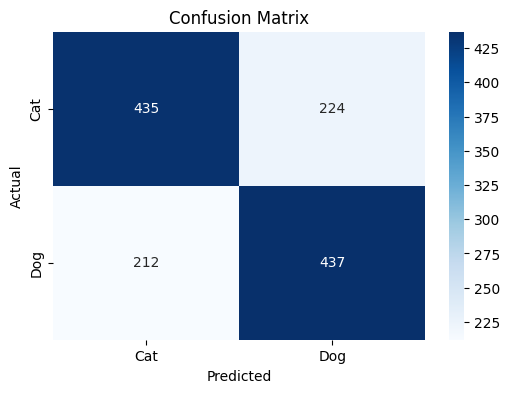

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Predictions

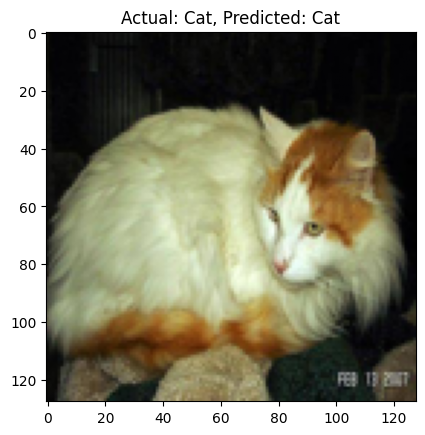

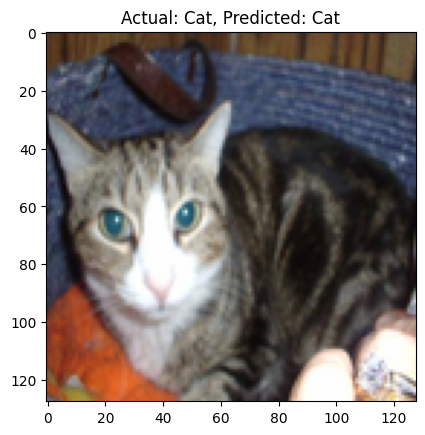

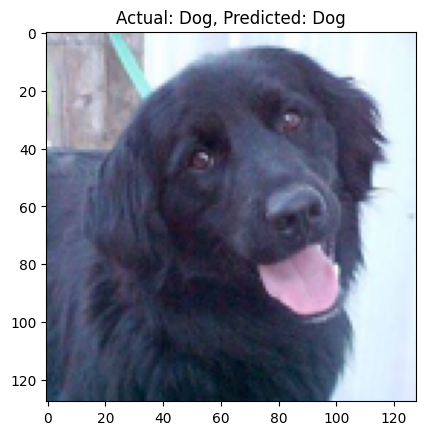

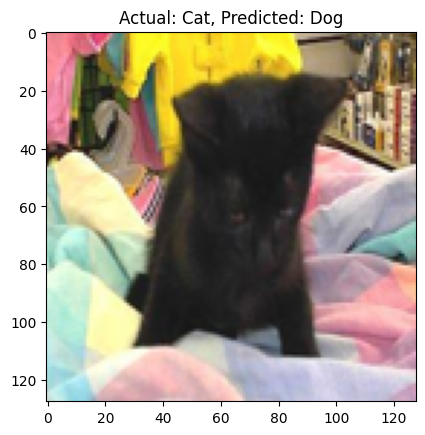

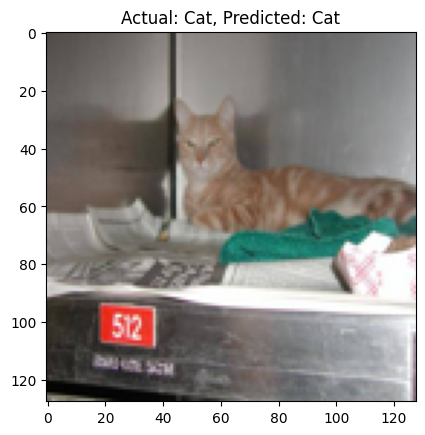

In [ ]:
for i in range(5):
    plt.imshow(X_test[i].reshape(128, 128, 3))
    plt.title(f"Actual: {'Dog' if y_test[i] == 1 else 'Cat'}, Predicted: {'Dog' if y_pred[i] == 1 else 'Cat'}")
    plt.show()
